A support vector machine (SVM) is a powerful and versatile machine learning model, capable of performing linear or nonlinear classification, regression, and even novelty detection. SVMs shine with small to medium-sized nonlinear datasets (i.e., hundreds to thousands of instances), especially for classification tasks. However, they don’t scale very well to very large datasets, as you will see.

This chapter will explain the core concepts of SVMs, how to use them, and how they work. Let’s jump right in!

**Iris Dataset**

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [ ]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [ ]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [ ]:
iris.target.head(3)  # note that the instances are not shuffled

,target
0,0
1,0
2,0


In [ ]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

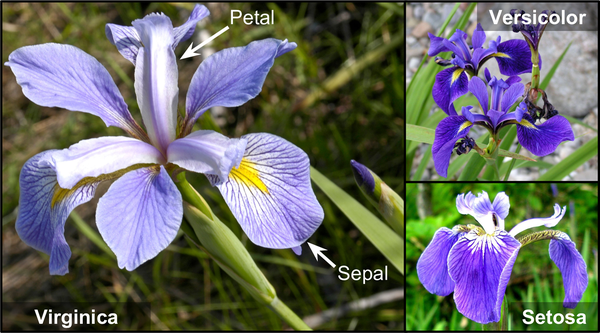

**Linear SVM Classification**

The fundamental idea behind SVMs is best explained with some visuals. Following figure shows part of the iris dataset. The two classes can clearly be separated easily with a straight line (they are linearly separable). The left plot shows the decision boundaries of three possible linear classifiers. The model whose decision boundary is represented by the dashed line is so bad that it does not even separate the classes properly. The other two models work perfectly on this training set, but their decision boundaries come so close to the instances that these models will probably not perform as well on new instances. In contrast, the solid line in the plot on the right represents the decision boundary of an SVM classifier; this line not only separates the two classes but also stays as far away from the closest training instances as possible. You can think of an SVM classifier as fitting the widest possible street (represented by the parallel dashed lines) between the classes. This is called large margin classification. <br>
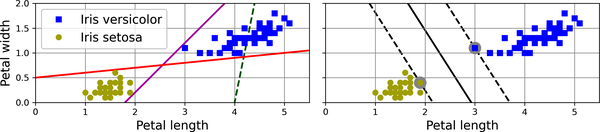







Notice that adding more training instances “off the street” will not affect the decision boundary at all: it is fully determined (or “supported”) by the instances located on the edge of the street. These instances are called the support vectors.

**WARNING** <br>
SVMs are sensitive to the feature scales, as you can see in following figure. In the left plot, the vertical scale is much larger than the horizontal scale, so the widest possible street is close to horizontal. After feature scaling (e.g., using Scikit-Learn’s StandardScaler), the decision boundary in the right plot looks much better. <br>
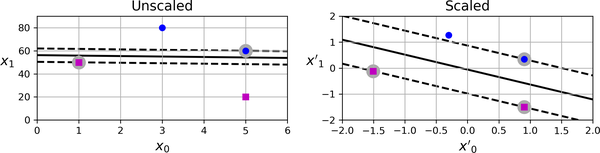

**Soft Margin Classification**

If we strictly impose that all instances must be off the street and on the correct side, this is called hard margin classification. There are two main issues with hard margin classification. First, it only works if the data is linearly separable. Second, it is sensitive to outliers. Following figure shows the iris dataset with just one additional outlier: on the left, it is impossible to find a hard margin; on the right, the decision boundary ends up very different from the one we saw in previous figure without the outlier, and the model will probably not generalize as well. <br>
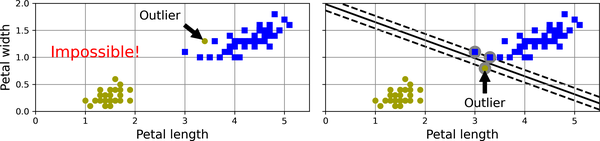

To avoid these issues, we need to use a more flexible model. The objective is to find a good balance between keeping the street as large as possible and limiting the margin violations (i.e., instances that end up in the middle of the street or even on the wrong side). This is called soft margin classification.

When creating an SVM model using Scikit-Learn, you can specify several hyperparameters, including the regularization hyperparameter C. If you set it to a low value, then you end up with the model on the left of following figure. With a high value, you get the model on the right. As you can see, reducing C makes the street larger, but it also leads to more margin violations. In other words, reducing C results in more instances supporting the street, so there’s less risk of overfitting. But if you reduce it too much, then the model ends up underfitting, as seems to be the case here: the model with C=100 looks like it will generalize better than the one with C=1. <br>
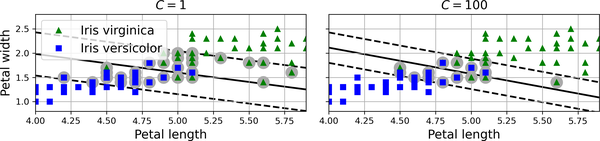

**TIP** <br>
If your SVM model is overfitting, you can try regularizing it by reducing C.

The following Scikit-Learn code loads the iris dataset and trains a linear SVM classifier to detect Iris virginica flowers. The pipeline first scales the features, then uses a LinearSVC with C=1:

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2)  # Iris virginica

svm_clf = make_pipeline(StandardScaler(),
                        LinearSVC(C=1, random_state=42))
svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, random_state=42))])

Then, as usual, you can use the model to make predictions:

In [ ]:
X_new = [[5.5, 1.7], [5.0, 1.5]]
svm_clf.predict(X_new)

array([ True, False])

The first plant is classified as an Iris virginica, while the second is not. Let’s look at the scores that the SVM used to make these predictions. These measure the signed distance between each instance and the decision boundary:

In [ ]:
svm_clf.decision_function(X_new)

array([ 0.66163411, -0.22036063])

**Nonlinear SVM Classification**

Although linear SVM classifiers are efficient and often work surprisingly well, many datasets are not even close to being linearly separable. One approach to handling nonlinear datasets is to add more features, such as polynomial features; in some cases this can result in a linearly separable dataset. Consider the lefthand plot in following figure: it represents a simple dataset with just one feature, x1. This dataset is not linearly separable, as you can see. But if you add a second feature $x_2 = (x_1)^2$, the resulting 2D dataset is perfectly linearly separable. <br>
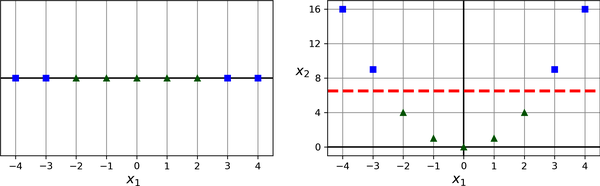



To implement this idea using Scikit-Learn, you can create a pipeline containing a PolynomialFeatures transformer, followed by a StandardScaler and a LinearSVC classifier. Let’s test this on the moons dataset, a toy dataset for binary classification in which the data points are shaped as two interleaving crescent moons (following figure). You can generate this dataset using the make_moons() function: <br>
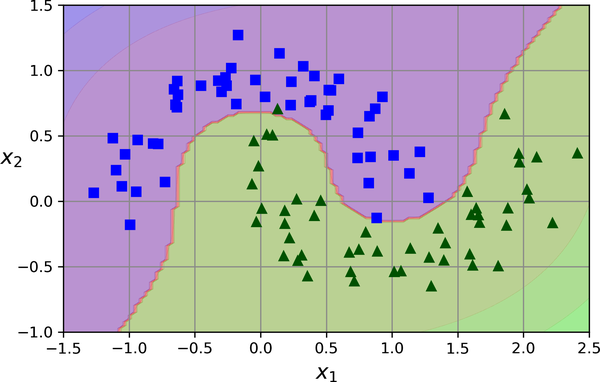

In [ ]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10_000, random_state=42)
)
polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, max_iter=10000, random_state=42))])

**Polynomial Kernel**

Adding polynomial features is simple to implement and can work great with all sorts of machine learning algorithms (not just SVMs). That said, at a low polynomial degree this method cannot deal with very complex datasets, and with a high polynomial degree it creates a huge number of features, making the model too slow.

Fortunately, when using SVMs you can apply an almost miraculous mathematical technique called the kernel trick. The kernel trick makes it possible to get the same result as if you had added many polynomial features, even with a very high degree, without actually having to add them. This means there’s no combinatorial explosion of the number of features. This trick is implemented by the SVC class. Let’s test it on the moons dataset:

In [ ]:
from sklearn.svm import SVC

poly_kernel_svm_clf = make_pipeline(StandardScaler(),
                                    SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

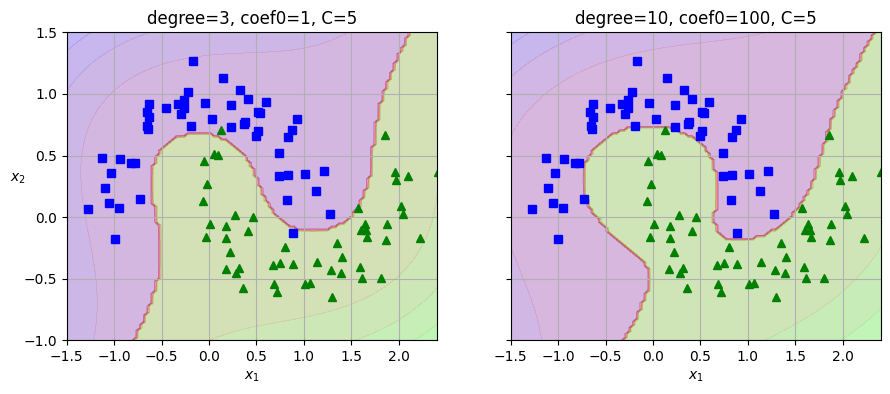

In [ ]:
import matplotlib.pyplot as plt

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

poly100_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=10, coef0=100, C=5)
)
poly100_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=3, coef0=1, C=5")

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=10, coef0=100, C=5")
plt.ylabel("")

plt.show()

This code trains an SVM classifier using a third-degree polynomial kernel, represented on the left in previous figure. On the right is another SVM classifier using a 10th-degree polynomial kernel. Obviously, if your model is overfitting, you might want to reduce the polynomial degree. Conversely, if it is underfitting, you can try increasing it. The hyperparameter coef0 controls how much the model is influenced by high-degree terms versus low-degree terms.

**Similarity Features**

Another technique to tackle nonlinear problems is to add features computed using a similarity function, which measures how much each instance resembles a particular landmark. For example, let’s take the 1D dataset from earlier and add two landmarks to it at x1 = –2 and x1 = 1 (see the left plot following figure). Next, we’ll define the similarity function to be the Gaussian RBF with γ = 0.3. This is a bell-shaped function varying from 0 (very far away from the landmark) to 1 (at the landmark). <br>
The kernel equation: K(x, x') = exp(-γ * ||x - x'||^2)

Now we are ready to compute the new features. For example, let’s look at the instance x1 = –1: it is located at a distance of 1 from the first landmark and 2 from the second landmark. Therefore, its new features are x2 = exp(–0.3 × 12) ≈ 0.74 and x3 = exp(–0.3 × 22) ≈ 0.30. The plot on the right in following figure shows the transformed dataset (dropping the original features). As you can see, it is now linearly separable. <br>
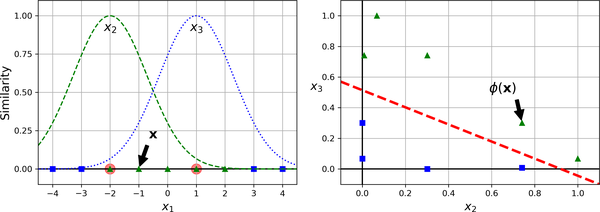

You may wonder how to select the landmarks. The simplest approach is to create a landmark at the location of each and every instance in the dataset. Doing that creates many dimensions and thus increases the chances that the transformed training set will be linearly separable. The downside is that a training set with m instances and n features gets transformed into a training set with m instances and m features (assuming you drop the original features). If your training set is very large, you end up with an equally large number of features.

**Gaussian RBF Kernel**

Just like the polynomial features method, the similarity features method can be useful with any machine learning algorithm, but it may be computationally expensive to compute all the additional features (especially on large training sets). Once again the kernel trick does its SVM magic, making it possible to obtain a similar result as if you had added many similarity features, but without actually doing so. Let’s try the SVC class with the Gaussian RBF kernel:

In [ ]:
rbf_kernel_svm_clf = make_pipeline(StandardScaler(),
                                   SVC(kernel="rbf", gamma=5, C=0.001))
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, gamma=5))])

This model is represented at the bottom left in following figure. The other plots show models trained with different values of hyperparameters gamma (γ) and C. Increasing gamma makes the bell-shaped curve narrower (see the lefthand plots in previous figure). As a result, each instance’s range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual instances. Conversely, a small gamma value makes the bell-shaped curve wider: instances have a larger range of influence, and the decision boundary ends up smoother. So γ acts like a regularization hyperparameter: if your model is overfitting, you should reduce γ; if it is underfitting, you should increase γ (similar to the C hyperparameter). <br>
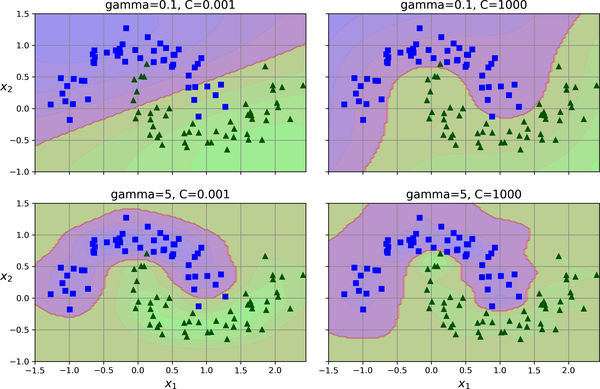

Other kernels exist but are used much more rarely. Some kernels are specialized for specific data structures. String kernels are sometimes used when classifying text documents or DNA sequences (e.g., using the string subsequence kernel or kernels based on the Levenshtein distance).

**TIP:** <br>
With so many kernels to choose from, how can you decide which one to use? As a rule of thumb, you should always try the linear kernel first. The LinearSVC class is much faster than SVC(kernel="linear"), especially if the training set is very large. If it is not too large, you should also try kernelized SVMs, starting with the Gaussian RBF kernel; it often works really well. Then, if you have spare time and computing power, you can experiment with a few other kernels using hyperparameter search. If there are kernels specialized for your training set’s data structure, make sure to give them a try too.

**SVM Regression**

To use SVMs for regression instead of classification, the trick is to tweak the objective: instead of trying to fit the largest possible street between two classes while limiting margin violations, SVM regression tries to fit as many instances as possible on the street while limiting margin violations (i.e., instances off the street). The width of the street is controlled by a hyperparameter, ϵ. Following figure shows two linear SVM regression models trained on some linear data, one with a small margin (ϵ = 0.5) and the other with a larger margin (ϵ = 1.2). <br>
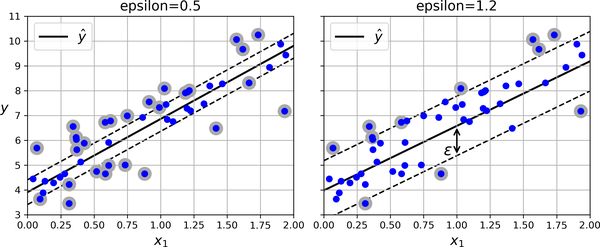

Reducing ϵ increases the number of support vectors, which regularizes the model. Moreover, if you add more training instances within the margin, it will not affect the model’s predictions; thus, the model is said to be ϵ-insensitive.

You can use Scikit-Learn’s LinearSVR class to perform linear SVM regression. The following code produces the model represented on the left in previous figure:

In [ ]:
from sklearn.svm import LinearSVR

# extra code – these 3 lines generate a simple linear dataset
np.random.seed(42)
X = 2 * np.random.rand(50, 1)
y = 4 + 3 * X[:, 0] + np.random.randn(50)

svm_reg = make_pipeline(StandardScaler(),
                        LinearSVR(epsilon=0.5, random_state=42))
svm_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(epsilon=0.5, random_state=42))])

To tackle nonlinear regression tasks, you can use a kernelized SVM model. Following figure shows SVM regression on a random quadratic training set, using a second-degree polynomial kernel. There is some regularization in the left plot (i.e., a small C value), and much less in the right plot (i.e., a large C value). <br>
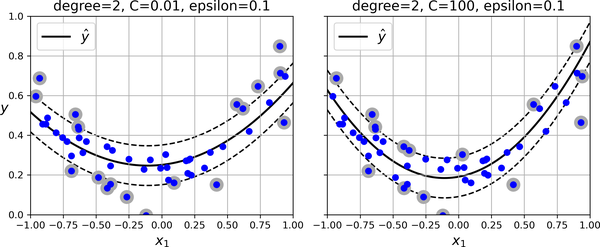

The following code uses Scikit-Learn’s SVR class (which supports the kernel trick) to produce the model represented on the left in previous figure:

In [ ]:
from sklearn.svm import SVR

# extra code – these 3 lines generate a simple quadratic dataset
np.random.seed(42)
X = 2 * np.random.rand(50, 1) - 1
y = 0.2 + 0.1 * X[:, 0] + 0.5 * X[:, 0] ** 2 + np.random.randn(50) / 10

svm_poly_reg = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1))
svm_poly_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.01, degree=2, kernel='poly'))])

The SVR class is the regression equivalent of the SVC class, and the LinearSVR class is the regression equivalent of the LinearSVC class. The LinearSVR class scales linearly with the size of the training set (just like the LinearSVC class), while the SVR class gets much too slow when the training set grows very large (just like the SVC class).